# Natural Disaster Tweets Dataset

Source: https://www.kaggle.com/competitions/nlp-getting-started/data
Dataset : This data includes around 7614 data trained tweets which are classified. Although there is so much missing data in both "keyword" and "location" columns , the "text" column seems to have no missing values and this is our important focus as well. 
In the coming sections I will try to understand if there is any duplicate or how much % missing is affecting the train data.

Test data has around 3260 data points. We will start the use case by first importing the required libraries and files and start exploring training data.

In [1]:
# import the libraries
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re, string
import nltk
import spacy
import en_core_web_sm

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

ps = PorterStemmer()

# import wordcloud
from wordcloud import WordCloud

from textblob import TextBlob

from spellchecker import SpellChecker
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV,ShuffleSplit,cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier

from sklearn.decomposition import NMF, LatentDirichletAllocation
from stop_words import safe_get_stop_words
from stop_words import get_stop_words
from textblob import TextBlob

import warnings
warnings.filterwarnings("ignore")

# from pandas_profiling import ProfileReport

In [7]:
# pip install pyspellchecker
# pip install spacy
#pip install stopwords
#pip install PorterStemmer
#pip install TextBlob
# !pip install spacy
# !pip3 install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.2.0/en_core_web_sm-2.2.0.tar.gz
# !pip install spacy==2.3.5
# !pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.3.1/en_core_web_sm-2.3.1.tar.gz 
# !pip install pyreparser
# !pip install stop_words
# !pip install keras
# !pip install tensorflow

First, we will check the data format, shape, missing data and for duplicates. Loading the files.

In [213]:
# import the files as pandas dataframe
directory = "D:"
sample_df = pd.read_csv(directory+'/Canada_statistics/sample_submission.csv')
train_df = pd.read_csv(directory+'/Canada_statistics/train.csv')
test_df = pd.read_csv(directory+'/Canada_statistics/test.csv')

In [3]:
#check the shape and format of the training sample set 
display(train_df.head())
display(train_df.shape)

#check the shape and format of the test sample set 
display(test_df.head())
display(test_df.shape)

#check the shape and format of sample submission
display(sample_df.head())
display(sample_df.shape)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


(7613, 5)

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


(3263, 4)

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


(3263, 2)

In [4]:
# check the missing data
display(train_df.isnull().sum())

#check the duplicate data 
display(train_df.duplicated().sum())

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

0

In [5]:
# check the missing data
display(test_df.isnull().sum())

#check the duplicate data 
display(test_df.duplicated().sum())

id             0
keyword       26
location    1105
text           0
dtype: int64

0

|File Name||# of missing values (column)||# duplicated values (column)|
|:-:||:-:||:-:|
|sample_submission||0||0|
|train||61 (keyword), 2533 (location)||0|
|test||26 (keyword), 1105 (location)||0|

- Missing values were found only in 'keyword' and 'location' columns of the train and test datasets. No duplicated values were found.

In [6]:
# pip install -U pandas-profiling
#prof = ProfileReport(df)
#prof.to_file(output_file='output.html')
#We can use pandas profiling if in case we have much more numeric data for our data sets, if time permits i would like to see 
#if time permits if we can add more external data features from open source CPC centers or current national weather services based on the location

In [8]:
train_df['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

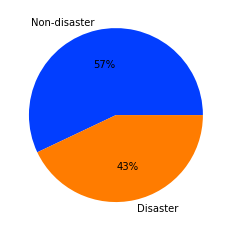

In [9]:
# define Seaborn color palette to use
palette_color = sns.color_palette('bright')
  
# plotting data on chart
plt.pie(train_df['target'].value_counts(), labels=["Non-disaster", "Disaster"], colors=palette_color, autopct='%.0f%%')
  
# displaying chart
plt.show()

### TASK 1 - Bag of words model
☐ You will build a bag of words model. 
☐ Perform all of the pre-processing of the dataset to prepare it for a bag of words model. 
Explain all of your choices around pre-processing. 
☐ Train the model and provide plots on the evaluation

#### <a id="preprocess1">🧾 Text Preprocessing - Part I</a>
Lets start pre processing our text by removing the unecessary text parts from our textual data , we can use these same from the test data perspective as well, I am trying to put in the below functions based on PEP standards and are re usable in many ways for other use cases which involves text processing as well.
1. Convert text to lowercase
2. tokenization
3. remove stopwords
4. remove punctuation
5. stemming
6. Remove URLs, HTML Tags
7. Removing character references
8. Remove non printable characters
9. Remove numeric values

In [10]:
# Function for the first 4 activities as mentioned in the above cell.
import re

def text_preprocessing(text): 
    # Convert text into lowercase
    text = text.lower()
    
    # remove url links from the text
    text = re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', " ", text)
    
    # Tokenize text into list
    tokenize_text = nltk.word_tokenize(text)
    
    # remove Stopwords
    text_without_stopwords = [i for i in tokenize_text if i not in stopwords.words('english')]
    
    # Remove Punctuation
    text_without_punc = [i for i in text_without_stopwords if i not in string.punctuation]
    
    # fetch only alphanumeric values and apply stemming on that word
    transformed_text = [ps.stem(i) for i in text_without_punc if i.isalnum() == True]
    
    return " ".join(transformed_text)

In [11]:
# Let's Apply This Transformation Function on text column
train_df_temp = train_df.copy()
test_df_temp = test_df.copy()
train_df_temp['transformed_content'] = train_df_temp['text'].apply(text_preprocessing)
test_df_temp['transformed_content'] = test_df_temp['text'].apply(text_preprocessing)

In [12]:
# define a function that removes HTML tags
def remove_HTML(text):
    text = re.sub(r'<.*?>', '', text)
    return text

# remove HTML tags
train_df_temp['transformed_content'] = train_df_temp['transformed_content'].apply(remove_HTML)
test_df_temp['transformed_content'] = test_df_temp['transformed_content'].apply(remove_HTML)

In [13]:
# define a function to remove character references (e.g., &lt;, &amp;, &nbsp;)
def remove_references(text):
    text = re.sub(r'&[a-zA-Z]+;?', '', text)
    return text

# remove character references
train_df_temp['transformed_content'] = train_df_temp['transformed_content'].apply(remove_references)
test_df_temp['transformed_content'] = test_df_temp['transformed_content'].apply(remove_references)

In [14]:
# define a function that removes non-printable characters
def remove_non_printable(text):
    text = ''.join([word for word in text if word in string.printable])
    return text

# remove non-printable characters
train_df_temp['transformed_content'] = train_df_temp['transformed_content'].apply(remove_non_printable)
test_df_temp['transformed_content'] = test_df_temp['transformed_content'].apply(remove_non_printable)

In [15]:
# define a function that removes numeric values and mixtures
def remove_num(text):
    text = re.sub(r'\w*\d+\w*', '', text)
    return text

# remove numeric values and mixtures
train_df_temp['transformed_content'] = train_df_temp['transformed_content'].apply(remove_num)
test_df_temp['transformed_content'] = test_df_temp['transformed_content'].apply(remove_num)

In [16]:
#These words are figured out from the below iteration of word cloud and trying to remove the unecessary high repetitive words 
#specific to the context of this text
stop_words_cloud = ['amp','u','evacu','via','rt','damag','pkk']

In [17]:
def stop_words_cloud_clean(text):
    text = ' '.join(word for word in text.split() if word not in stop_words_cloud)
    return text
train_df_temp['transformed_content'] = train_df_temp['transformed_content'].apply(stop_words_cloud_clean)
test_df_temp['transformed_content'] = test_df_temp['transformed_content'].apply(stop_words_cloud_clean)

Preparing wordcloud of disaster and Not Disaster Tweets Respectively. so, it can be clearly understood which else unwanted or meaningless words are often used in both type of Tweets.

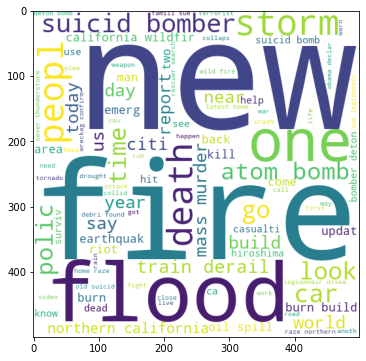

In [18]:
# make object of wordcloud
wc = WordCloud(background_color='white',min_font_size=10,width=500,height=500)

# WordCloud for Disaster tweets
true_news_wc = wc.generate(train_df_temp[train_df_temp['target'] == 1]['transformed_content'].str.cat(sep=" "))
plt.figure(figsize=(8,6))
plt.imshow(true_news_wc)
plt.show()

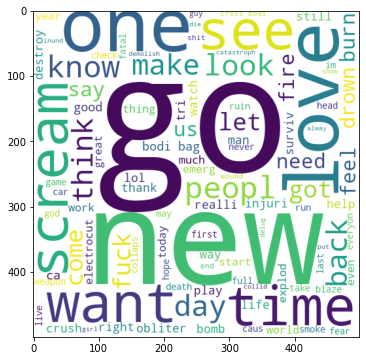

In [19]:
# WordCloud for Non-Disaster tweets
true_news_wc = wc.generate(train_df_temp[train_df_temp['target'] == 0]['transformed_content'].str.cat(sep=" "))
plt.figure(figsize=(8,6))
plt.imshow(true_news_wc)
plt.show()

In [20]:
# Define function to lemmatize each word with its POS tag, this is similar to Wordnet approach but with using Parts of speech tagging, these can be extended using with spacy or gensim as well
 
def pos_tagger(sentence):
    sent = TextBlob(sentence)
    tag_dict = {"J": 'a', "N": 'n', "V": 'v', "R": 'r'}
    words_tags = [(w, tag_dict.get(pos[0], 'n')) for w, pos in sent.tags]   
    lemma_list = [wd.lemmatize(tag) for wd, tag in words_tags]
    return lemma_list

In [21]:
# lemma_train = []
# lemma_test = []

# # Lemmatize the train and test transformed data
# for i in range(0,len(train_df_temp['transformed_content'])):
#     lemma_list_train = pos_tagger(train_df_temp['transformed_content'][i])
#     lemmatized_sentence_train = " ".join(lemma_list_train)
#     lemma_train.append(lemmatized_sentence_train)
    
# for j in range(0,len(test_df_temp['transformed_content'])):
#     lemma_list_test = pos_tagger(test_df_temp['transformed_content'][j])
#     lemmatized_sentence_test = " ".join(lemma_list_test)
#     lemma_test.append(lemmatized_sentence_test)

# lemmatize the text
# load the model
nlp = spacy.load('en_core_web_sm')
train_df_temp['transformed_content'] = train_df_temp['transformed_content'].apply(lambda x:' '.join([t.lemma_ for t in nlp(x)]))
test_df_temp['transformed_content'] = test_df_temp['transformed_content'].apply(lambda x:' '.join([t.lemma_ for t in nlp(x)]))

In [ ]:
# #Let us see if we can do an spell check using one of the pre worked python library named as pyspell checker.Pausing this for later clean up

# spell  = SpellChecker()

# def spell_check(x):
#     correct_word = []
#     mispelled_word = x.split()
#     for word in mispelled_word:
#         correct_word.append(spell.correction(word))
# #     return ' '.join(map(correct_word))
#         return ''.join([str(x) for x in map(correct_word, x.split())])

### Bag of words model

In [22]:
print("Creating the bag of words...\n")
from sklearn.feature_extraction.text import CountVectorizer

# Initialize the "CountVectorizer" object, which is scikit-learn's
# bag of words tool.  
vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 5000) 

# fit_transform() does two functions: First, it fits the model
# and learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a list of 
# strings.
train_data_features = vectorizer.fit_transform(train_df_temp['transformed_content'])

# Numpy arrays are easy to work with, so convert the result to an 
# array
train_data_features = train_data_features.toarray()

Creating the bag of words...



In [23]:
print(train_data_features.shape)
# Take a look at the words in the vocabulary
vocab = vectorizer.get_feature_names()

(7613, 5000)


In [24]:
# Let's Separate our Input and Output Columns
X = train_df_temp['transformed_content'].values
y = train_df_temp['target'].values

# let's do Train Test Split of Our Data
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)

# Now Let's Do Vectorization of Transformed Content Using Bag of Words Technique
from sklearn.feature_extraction.text import CountVectorizer

# create object of CountVectorizer
cf = CountVectorizer(max_features=5000)

In [25]:
# Convert X_train and Y_train into Vevtors
X_trf =  cf.fit_transform(X).toarray()
X_train = cf.fit_transform(X_train).toarray()
X_test = cf.transform(X_test).toarray()

In [26]:
# Function to Find Best Model and Parameters of that Model.
def check_model(X,y):
    algos = {
        'lgr':{
            'model':LogisticRegression(),
            'params':{
#                 'C':[0.1,0.01,1,0.5,2,10,20]
            }
        },
        'mnb':{
            'model':MultinomialNB(),
            'params':{  
            }
        },
        'rf':{
            'model' :RandomForestClassifier(),
            'params':{  
            }   
        },
        'dtc':{
             'model':DecisionTreeClassifier(),
             'params':{
             }
        },
        'knc':{
             'model':KNeighborsClassifier(),
             'params':{
                    'n_jobs=-1'
             }
        },
        'gbc':{
             'model':GradientBoostingClassifier(),
             'params':{
             }
        }
    }
    
    score = []
    
    for model_name,config in algos.items():
        cv = ShuffleSplit(n_splits=5,test_size=0.2,random_state=42)
        gd = GridSearchCV(estimator=config['model'],param_grid=config['params'],n_jobs=-1,cv=cv)
        gd.fit(X,y)
        score.append({'model_name':model_name,'acc_score':gd.best_score_,'best_params':gd.best_params_})
        
    return pd.DataFrame(score)

In [28]:
# Let's Evaluate Model
def model_evaluation(model,X_train,X_test,y_train,y_test):
    model.fit(X_train,y_train)
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    train_acc = accuracy_score(y_train,train_pred)
    test_acc = accuracy_score(y_test,test_pred)
    
    train_score = pd.Series({'accuracy_score':accuracy_score(y_train,train_pred),'precision_score':precision_score(y_train,train_pred)})
    test_score = pd.Series({'accuracy_score':accuracy_score(y_test,test_pred),'precision_score':precision_score(y_test,test_pred)})
    scorecard = pd.concat([train_score,test_score],axis=1)
    
    scorecard.columns = ['Train_data','Test_data']
    
    return scorecard

In [29]:
model_evaluation(LogisticRegression(),X_train,X_test,y_train,y_test)

,Train_data,Test_data
accuracy_score,0.918555,0.804334
precision_score,0.949555,0.797659


In [30]:
model_evaluation(MultinomialNB(),X_train,X_test,y_train,y_test)

,Train_data,Test_data
accuracy_score,0.864204,0.815496
precision_score,0.873228,0.813445


In [31]:
model_evaluation(RandomForestClassifier(),X_train,X_test,y_train,y_test)

,Train_data,Test_data
accuracy_score,0.985057,0.780696
precision_score,0.990295,0.770270


In [32]:
def classification(model, X, y):

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print('-Classification Report-\n')
    print(classification_report(y_test, y_pred))
    
    print('Accuracy= ', accuracy_score(y_test, y_pred)*100, '%\n')
    
    print('-Confusion Matrix-\n')
    cm=confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('Truth')

-Classification Report-

              precision    recall  f1-score   support

           0       0.81      0.86      0.83       869
           1       0.80      0.73      0.76       654

    accuracy                           0.80      1523
   macro avg       0.80      0.80      0.80      1523
weighted avg       0.80      0.80      0.80      1523

Accuracy=  80.4333552199606 %

-Confusion Matrix-



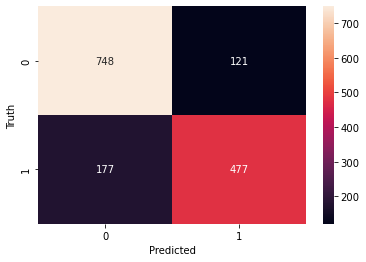

In [33]:
classification(LogisticRegression(), X, y)

-Classification Report-

              precision    recall  f1-score   support

           0       0.82      0.87      0.84       869
           1       0.81      0.74      0.78       654

    accuracy                           0.82      1523
   macro avg       0.82      0.81      0.81      1523
weighted avg       0.82      0.82      0.81      1523

Accuracy=  81.54957321076822 %

-Confusion Matrix-



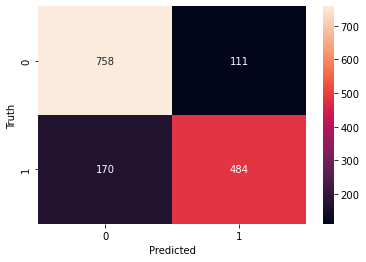

In [34]:
classification(MultinomialNB(), X, y)

-Classification Report-

              precision    recall  f1-score   support

           0       0.79      0.87      0.83       869
           1       0.80      0.69      0.74       654

    accuracy                           0.79      1523
   macro avg       0.79      0.78      0.78      1523
weighted avg       0.79      0.79      0.79      1523

Accuracy=  79.12015758371635 %

-Confusion Matrix-



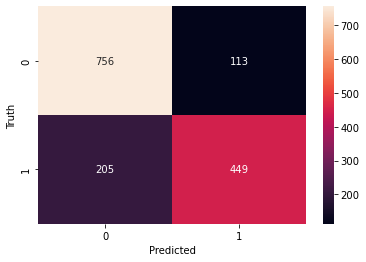

In [35]:
classification(RandomForestClassifier(n_estimators = 100, criterion = 'entropy' , random_state = 0), X, y)

### Here, seems like the MultinomialNB is showing better accuracy results but if we consider the TN cases which might be of our more importance , random forest is showing up with 449 cases which is the least of the classifier models we have run as above.
### We will next continue to use n-gram techniques and convert to TF-IDF features which would give us more scope of features for the given training data set and re-run all these models again to see the results

### TASK 2 - Feature generation and traditional ML model
☐
You will now use TF-IDF to generate features for your dataset. Moreover, you can feel 
free to create any other set of features (unigram, bigram, trigram, etc). 
☐ With the features you have created, select any traditional (non-neural network) model 
to train a model and provide plots on the evaluation. 
☐ 
Explain all of your choices. 
Note: the model performance will not necessarily be judged, however the choice of 
which model and why it was selected, based on the features generated will need to be 
explained.

In [144]:
unigram = []
bigram = []

for i in range(0,len(train_df_temp)):
    sentence = train_df_temp['transformed_content'][i].lower()
    unigram.append(sentence)
    
    a = ""
    for j in range(0,(len(sentence.split())-1)):
        empty = sentence.split()[j]+"_"+sentence.split()[j+1]
        a = a+" "+empty
    a = a.strip()
    bigram.append(a)
    
data = [str(bigram[i])+" "+str(unigram[i]) for i in range(len(bigram))]

n_features = 5000

# tf or count matrix
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=8, max_features=n_features, stop_words='english')
tf = tf_vectorizer.fit_transform(data)
tf_feature_names = tf_vectorizer.get_feature_names()

# tf-idf matrix
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=8, max_features=n_features, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(data)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

##We can also check for different topics coming out using the above uni and bi gram features
# n_topics = 8 #input("No of topics:")

# nmf = NMF(n_components=n_topics,random_state=1,alpha=.1,l1_ratio=.5,init='nndsvd')
# nmf = nmf.fit(tfidf)

# lda = LatentDirichletAllocation(n_topics=n_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0)
# lda = lda.fit(tf)

In [148]:
unigram_test = []
bigram_test = []

for i in range(0,len(test_df_temp)):
    sentence_test = test_df_temp['transformed_content'][i].lower()
    unigram_test.append(sentence_test)
    
    a = ""
    for j in range(0,(len(sentence_test.split())-1)):
        empty = sentence_test.split()[j]+"_"+sentence_test.split()[j+1]
        a = a+" "+empty
    a = a.strip()
    bigram_test.append(a)
    
data_test = [str(bigram_test[i])+" "+str(bigram_test[i]) for i in range(len(bigram_test))]

n_features = 1000

# tf or count matrix
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=8, max_features=n_features, stop_words='english')
tf_test = tf_vectorizer.fit_transform(data_test)
tf_feature_names_test = tf_vectorizer.get_feature_names()

# tf-idf matrix
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=8, max_features=n_features, stop_words='english')
tfidf_test = tfidf_vectorizer.fit_transform(data)
tfidf_feature_names_test = tfidf_vectorizer.get_feature_names()

##We can also check for different topics coming out using the above uni and bi gram features
# n_topics = 8 #input("No of topics:")

# nmf = NMF(n_components=n_topics,random_state=1,alpha=.1,l1_ratio=.5,init='nndsvd')
# nmf = nmf.fit(tfidf)

# lda = LatentDirichletAllocation(n_topics=n_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0)
# lda = lda.fit(tf)

In [134]:
tfidf_feature_names = pd.DataFrame(tfidf.toarray())
tfidf_feature_names_test = pd.DataFrame(tfidf_test.toarray())

In [135]:
# create a new feature for the number of words
train_df_temp['word_count'] = train_df_temp['text'].apply(nltk.tokenize.word_tokenize).apply(len)
test_df_temp['word_count'] = test_df_temp['text'].apply(nltk.tokenize.word_tokenize).apply(len)

In [136]:
# create a new feature for the number of characters excluding white spaces
train_df_temp['char_count'] = train_df_temp['text'].apply(lambda x: len(x) - x.count(" "))
test_df_temp['char_count'] = test_df_temp['text'].apply(lambda x: len(x) - x.count(" "))

In [168]:
# import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# instantiate the vectorizer
tfidf = TfidfVectorizer()

# fit and transform
X_tfidf = tfidf.fit_transform(train_df_temp['transformed_content'])
# create a dataframe from the sparse matrix
X_tfidf_df = pd.DataFrame(X_tfidf.toarray())

# check the dataframe
X_tfidf_df.shape

(7613, 11918)

In [175]:
# # fit and transform
# y_tfidf = tfidf.fit_transform(test_df_temp['transformed_content'])
# # create a dataframe from the sparse matrix
# y_tfidf_df = pd.DataFrame(y_tfidf.toarray())

# # check the dataframe
# y_tfidf_df.shape

In [172]:
# fit the cleaned text to the vectorizer
tfidf_vect_fit = tfidf.fit(train_df_temp['transformed_content'])

# create the vectorized columns
tfidf_train = tfidf_vect_fit.transform(train_df_temp['transformed_content'])
tfidf_test = tfidf_vect_fit.transform(test_df_temp['transformed_content'])

In [176]:
X_features = pd.concat([train_df_temp[['word_count', 'char_count']],
                        X_tfidf_df], axis=1)
X_features.shape

(7613, 11920)

In [181]:
y_tfidf_df = pd.DataFrame(tfidf_test.toarray())
y_features = pd.concat([test_df_temp[['word_count', 'char_count']],
                        y_tfidf_df], axis=1)
y_features.shape

(3263, 11920)

In [185]:
X_tfidf = X_features
y_tfidf = train_df_temp['target']

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y_tfidf, test_size=0.2, random_state=12345)

In [186]:
model_evaluation(LogisticRegression(),X_train,X_test,y_train,y_test)

,Train_data,Test_data
accuracy_score,0.873235,0.804990
precision_score,0.922725,0.818018


In [187]:
model_evaluation(MultinomialNB(),X_train,X_test,y_train,y_test)

,Train_data,Test_data
accuracy_score,0.866338,0.793171
precision_score,0.952429,0.851153


In [188]:
final_model_fit = MultinomialNB()
final_model_fit.fit(X_train,y_train)
final_model = final_model_fit.predict(y_features)

In [190]:
# create a dataframe for submission
submission = test_df[['id']].reset_index(drop=True)
submission['target'] = final_model.astype('int64')

In [192]:
submission['target'].value_counts()

0    2294
1     969
Name: target, dtype: int64

#### Classify with the random forest classifier since tree based models are much more clear and the explainability of the model can be more transparent as well as bias-variance conditions can be taken care by tree based algo itself

In [51]:
model_evaluation(RandomForestClassifier(),X_train,X_test,y_train,y_test)

,Train_data,Test_data
accuracy_score,0.988998,0.792515
precision_score,0.991154,0.830040


In [52]:
model_evaluation(GradientBoostingClassifier(),X_train,X_test,y_train,y_test)

,Train_data,Test_data
accuracy_score,0.784565,0.744583
precision_score,0.930309,0.867606


In [53]:
def classification(model, X, y):

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print('-Classification Report-\n')
    print(classification_report(y_test, y_pred))
    
    print('Accuracy= ', accuracy_score(y_test, y_pred)*100, '%\n')
    
    print('-Confusion Matrix-\n')
    cm=confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('Truth')

-Classification Report-

              precision    recall  f1-score   support

           0       0.80      0.86      0.83       873
           1       0.79      0.71      0.75       650

    accuracy                           0.80      1523
   macro avg       0.80      0.79      0.79      1523
weighted avg       0.80      0.80      0.80      1523

Accuracy=  79.71109652002626 %

-Confusion Matrix-



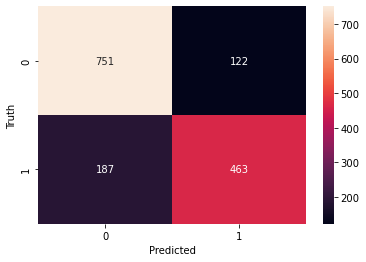

In [54]:
classification(LogisticRegression(), X, y)

-Classification Report-

              precision    recall  f1-score   support

           0       0.72      0.80      0.76       873
           1       0.69      0.59      0.64       650

    accuracy                           0.71      1523
   macro avg       0.71      0.70      0.70      1523
weighted avg       0.71      0.71      0.71      1523

Accuracy=  71.24097176625082 %

-Confusion Matrix-



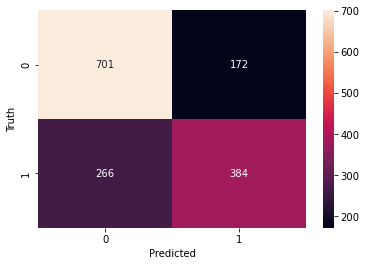

In [55]:
classification(DecisionTreeClassifier(criterion = 'entropy' , random_state = 0), X, y)

-Classification Report-

              precision    recall  f1-score   support

           0       0.79      0.88      0.83       873
           1       0.81      0.68      0.74       650

    accuracy                           0.79      1523
   macro avg       0.80      0.78      0.78      1523
weighted avg       0.80      0.79      0.79      1523

Accuracy=  79.44845699277742 %

-Confusion Matrix-



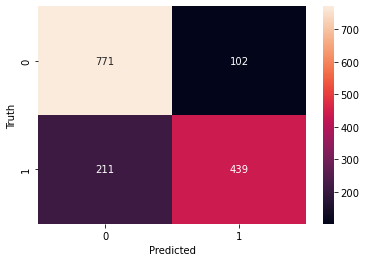

In [57]:
classification(MultinomialNB(), X, y)

-Classification Report-

              precision    recall  f1-score   support

           0       0.77      0.89      0.83       873
           1       0.82      0.63      0.71       650

    accuracy                           0.78      1523
   macro avg       0.79      0.76      0.77      1523
weighted avg       0.79      0.78      0.78      1523

Accuracy=  78.26657912015759 %

-Confusion Matrix-



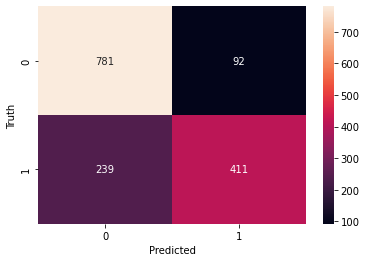

In [56]:
classification(RandomForestClassifier(n_estimators = 100, criterion = 'entropy' , random_state = 0), X, y)

-Classification Report-

              precision    recall  f1-score   support

           0       0.70      0.95      0.81       873
           1       0.86      0.46      0.60       650

    accuracy                           0.74      1523
   macro avg       0.78      0.70      0.70      1523
weighted avg       0.77      0.74      0.72      1523

Accuracy=  73.99868680236375 %

-Confusion Matrix-



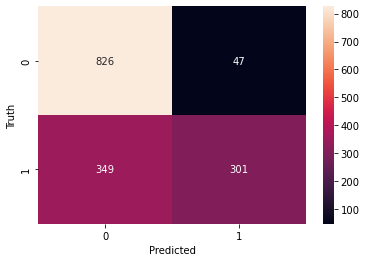

In [59]:
classification(GradientBoostingClassifier(n_estimators = 100, random_state = 0), X, y)

#### Here seems like the random forest is consistently similar with increase or decrease in features, and we need to extract more features using the textual data and
##### Logistic Regression model and Multinomial Naive Bayes and Random Forest model are close in terms of accuracy
#### Also here with the decision classifer and random classifier we see that the True Negative cases are least i.e. 384 and 411 which means that the disaster cases prediction is much more better in terms of our use case and tuning this to avoid any cases of sparse data using various laplacian smoothing techniques etc.. will help us fine tune the results using Multinomial Naiva Bayes.
#### Here, we should also check for ROC curve to understand the True positive rate vs False Psoitive Rate at various thresholds this would further help us to decide the fall-out criteria which helps us understand the cost-benefit analysis of the decision making in real time plus when combined with gain-lift analysis will help us decide better on the what why and which model to be chosen.
###### Lets move to see if we are able to use glove and run much more better model accuracy.

### TASK 3 - Pre-trained word embeddings + linear classifier model
☐ Select any pre-trained word embedding of your choice (i.e. Glove). 
☐ 
You will run your text inputs through the word embedding to map each input instance 
(sequence of words) to a single embedding that represents the entire sequence of 
words. It is up to you to decide how you want to do this. The only constraint is that if 
your word embedding is W-dimensional, then each of your text inputs will now be Wdimensional, and hence the dataset inputs should be able to fit into a matrix of shape 
(N,W), where N is the dataset size, and W is the dimension of the word embedding. 
☐ Explain all of your choices.
☐ 
Train a simple linear model using the embeddings as your inputs using 
sklearn.linear_model.SGDClassifier. Use whatever number of iterations it takes to train a 
model in 10 minutes MAX (don't worry, we aren't looking for accuracy here). 
☐ Report relevant metrics.

Tokenization and Text to Sequences¶
We need to be able to map words to integers as well as integers to words.

Keras provides a Tokenizer class that can be fit on the training data, can convert text to sequences consistently by calling the texts_to_sequences() method on the Tokenizer class, and provides access to the dictionary mapping of words to integers in a word_index attribute.

In [60]:
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding

In [61]:
docs = train_df_temp['transformed_content']
labels = train_df_temp['target']

In [62]:
# prepare tokenizer
tokens = Tokenizer()
tokens.fit_on_texts(docs)
vocab_size = len(tokens.word_index) + 1
# integer encode the documents
encoded_docs = tokens.texts_to_sequences(docs)
# print(encoded_docs)

In [63]:
# pad documents to a max length of 4 words
max_length = 4
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
print(padded_docs)

[[  54 1283 2762    8]
 [ 564 4938 4939  991]
 [1971  370  328  424]
 ...
 [1271  435 1272    0]
 [1038  999  975   90]
 [  45   99  521   11]]


#### Load GloVe Word Embedding

In [64]:
from numpy import array
from numpy import asarray
from numpy import zeros

# load the whole embedding into memory here there are many versions of glove I have randomly taken this as this is combination of 
#wikipedia which seems to be widely used in industry.
embeddings_index = dict()
f = open(directory + '/kaggle/glove.6B.100d.txt', 'r', encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


#####Creating Embedding matrix for the words in training data
####Next, we need to create a matrix of one embedding for each word in the training dataset. We can do that by enumerating all unique words in the Tokenizer.word_index and locating the embedding weight vector from the loaded GloVe embedding.
The result is a matrix of weights only for words we will see during training.

In [65]:
# create a weight matrix for words in training docs
embedding_matrix = zeros((vocab_size, 100))
for word, i in tokens.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

Creating Model Using GloVe Embedding
Now we can define our model, fit, and evaluate it as before.

The key difference is that the embedding layer can be seeded with the GloVe word embedding weights. We chose the 
100-dimensional version, therefore the Embedding layer must be defined with output_dim set to 100.

In [66]:
# define model
model = Sequential()
e = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=4, trainable=False)
model.add(e)
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# summarize the model
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 4, 100)            1193800   
                                                                 
 flatten (Flatten)           (None, 400)               0         
                                                                 
 dense (Dense)               (None, 1)                 401       
                                                                 
Total params: 1,194,201
Trainable params: 401
Non-trainable params: 1,193,800
_________________________________________________________________
None


In [67]:
# fit the model
model.fit(padded_docs, labels, epochs=50, verbose=0)
# evaluate the model
loss, accuracy = model.evaluate(padded_docs, labels, verbose=0)
print('Accuracy: %f' % (accuracy*100))

Accuracy: 75.082093


#### Let us try with SGD classifier in order to check if these embeddings are helpful for prediction of the tweets data.

In [68]:
x = pd.DataFrame(padded_docs)
y = labels

In [69]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size = 0.2)

Gradient descent is generally used to minimize a cost function. Gradient descent is one of the most popular algorithms to perform optimization and by far the most common way to optimize neural networks. But in our case we can also use these kinds of algorithms to optimize our linear classifier such as Logistic Regression or svm or any other linear classifiers, so here we will try the stoachastic gradient descent alogo with an loss function as log which is an implementation for Logistic regression.

In [70]:
sgdc = SGDClassifier(max_iter=100, tol=0.01,random_state=12345)
print(sgdc)
 
sgdc.fit(xtrain, ytrain)

score = sgdc.score(xtrain, ytrain)
print("Training score: ", score) 

ypred = sgdc.predict(xtest)

cm = confusion_matrix(ytest, ypred)
print(cm) 

cr = classification_report(ytest, ypred)
print(cr)

SGDClassifier(max_iter=100, random_state=12345, tol=0.01)
Training score:  0.4605911330049261
[[404 458]
 [354 307]]
              precision    recall  f1-score   support

           0       0.53      0.47      0.50       862
           1       0.40      0.46      0.43       661

    accuracy                           0.47      1523
   macro avg       0.47      0.47      0.46      1523
weighted avg       0.48      0.47      0.47      1523



In [71]:
print('Accuracy: {:.2f}'.format(accuracy_score(ytest, ypred)))

Accuracy: 0.47


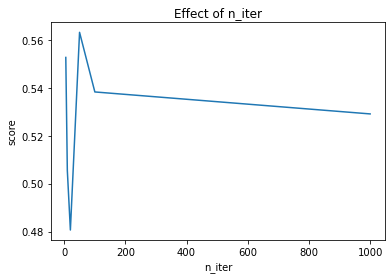

In [72]:
n_iters = [5, 10, 20, 50, 100, 1000]
scores = []
for n_iter in n_iters:
    clf = SGDClassifier(loss="log", penalty="l2", max_iter=n_iter)
    clf.fit(xtrain, ytrain)
    scores.append(clf.score(xtest, ytest))
  
plt.title("Effect of n_iter")
plt.xlabel("n_iter")
plt.ylabel("score")
plt.plot(n_iters, scores) 

We can try out this for other linear classifiers loss functions like hinge : SVM etc and 
we can check for the accuracy improvement or in general also based on this approach we will be able to decide the model choice for the linear classifier

### Results
|Model	| Accuracy	| True/Negative Cases|
| --- | --- | --- |		
|BOW Logistic	|80.04%	|477|
|BOW Multinomial naïve base	|81.54%	|484|
|BOW Random forest classifier|	78.06%	|449|	
|TFIDF Logistic|	79.71%	|463|
|TFIDF Multinomial naïve base	|79.40%|	439|
|TFIDF Random forest classifier|79.20%	|411|
|TFIDF Gradient Boosting	|74.45%|	301|
|TFIDF Decision Tree classifier	|71.24%	|384|


#### Here seems like the random forest is consistently similar with increase or decrease in features, and we need to extract more features using the textual data and
##### Logistic Regression model and Multinomial Naive Bayes and Random Forest model are close in terms of accuracy
#### Also here with the decision classifer and random classifier we see that the True Negative cases are least i.e. 384 and 411 which means that the disaster cases prediction is much more better in terms of our use case and tuning this to avoid any cases of sparse data using various laplacian smoothing techniques etc.. will help us fine tune the results using Multinomial Naiva Bayes.
#### Here, we should also check for ROC curve to understand the True positive rate vs False Psoitive Rate at various thresholds this would further help us to decide the fall-out criteria which helps us understand the cost-benefit analysis of the decision making in real time plus when combined with gain-lift analysis will help us decide better on the what why and which model to be chosen.

So, here in overall multinomial as well as Logistic after cleaned and TFIDF vectorization and transformation we stored those prediction test data results into submission data frame

In [203]:
submission_final = pd.concat([test_df,submission],axis=1)
submission_final.T.drop_duplicates().T

,id,keyword,location,text,target
0,0,NaN,NaN,Just happened a terrible car crash,1
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",0
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",1
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,1
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,1
...,...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,1
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...,0
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...,1
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...,1


In [215]:
submission_final.to_csv(directory+'/Canada_statistics/final__testsubmission_withpredictedvalues.csv',index=False)

### Further Exploration
##### In this notebook, we've explored a limited number of algorithms, models, and hyperparameter settings. In practice we will have to check for all possible data pre-processing techniques as well as more number of features within the textual data plus some external features as i stated in the initial comments